In [31]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc

## Model Training

In this notebook we will be looking to train the XGBoost model and see how good our features are for the model, checking statistics like accuracy, F-1 score, etc.

First, let's separate our target and our features.

In [32]:
# Load the teams data
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

label = 'PlayoffNextSeason'
features = [
    'Rank', 'PlayoffProgScore', 'FTA', 'DREB', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach'
]

# Prepare feature and label data
X = dataset[features]
y = dataset[label]

We then plotted a correlation matrix and mutual information classification table to distinguish our most important features.

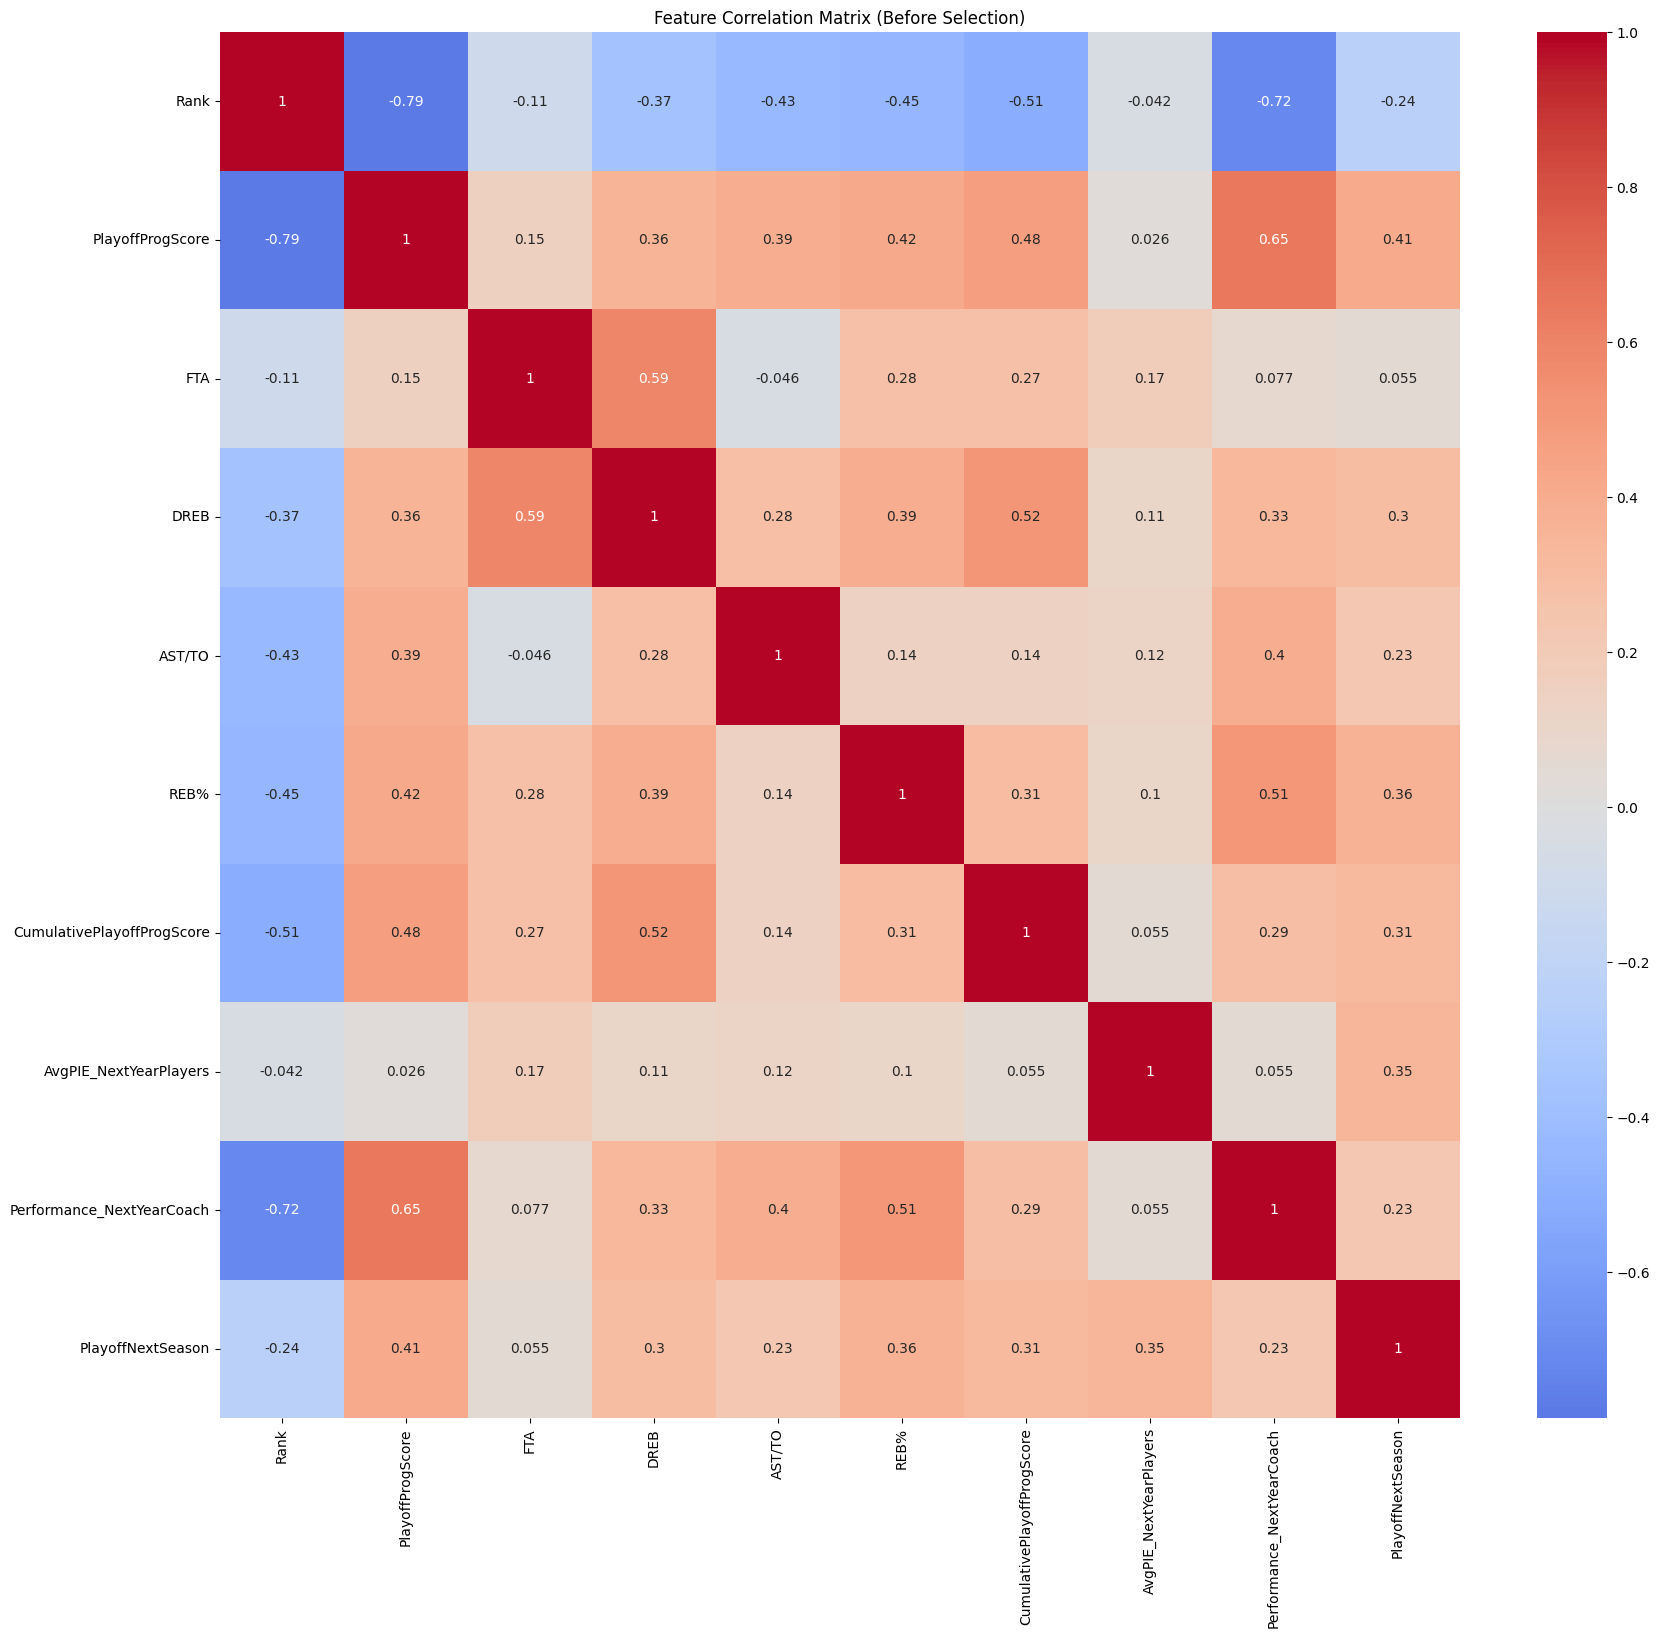

In [33]:
# ============================
# Display Initial Correlation Matrix
# ============================

# Calculate and plot the correlation matrix
correlation_matrix = dataset[features + [label]].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Before Selection)')
plt.show()

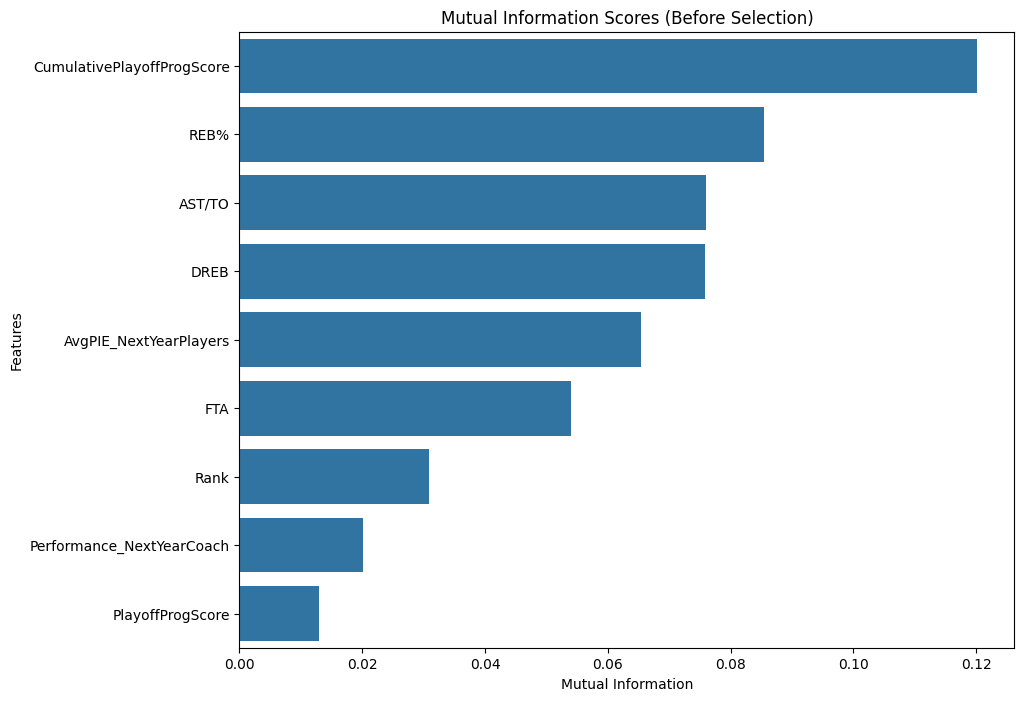

In [34]:
# ============================
# Display Initial Mutual Information Scores
# ============================

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.title('Mutual Information Scores (Before Selection)')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

Then we identified which features had a correlation above 0.9 with the target variable.

In [35]:
# ============================
# Define the XGBoost model
# ============================

def create_model(trial):
    return XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        gamma=trial.suggest_float('gamma', 0, 5),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 0, 1),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 100)
    )

After defining the model, `StratifiedKFold` with K=10 was used to mantain class distribution in each fold. We also defined a custom scorer for specificity, which is the true negative rate. This ensures that the cross-validation process is robust.

In [36]:
# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

#### Hyperparameter Tuning

`Optuna` was used in order to find the best hyperparameters for this model. An objective function was created to combine mean accuracy and mean AUC to evaluate the model's performance, and StratifiedKFold cross-validation to do the same.

In [37]:
# ============================
# Hyperparameter Tuning with Optuna
# ============================
def objective(trial):
    model = create_model(trial)
    cv_results = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_auc = np.mean(cv_results['test_roc_auc'])

    return 0.6 * mean_accuracy + 0.4 * mean_auc
    
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

# Use the best hyperparameters to create the final model
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best Value:", study.best_value)

final_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')

[I 2024-12-20 13:21:02,275] A new study created in memory with name: no-name-f274f52d-a9d8-422b-8278-5217fef7641e
[I 2024-12-20 13:21:02,611] Trial 1 finished with value: 0.7215510204081632 and parameters: {'learning_rate': 0.1772409319712387, 'n_estimators': 493, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.5383815064418693, 'colsample_bytree': 0.7197052193605551, 'gamma': 1.8957055309712512, 'reg_alpha': 0.8467090371996647, 'reg_lambda': 0.0707894252704856, 'scale_pos_weight': 93.28965933658301}. Best is trial 1 with value: 0.7215510204081632.
[I 2024-12-20 13:21:02,684] Trial 8 finished with value: 0.6865918367346939 and parameters: {'learning_rate': 0.1088666892714383, 'n_estimators': 66, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6388394049411505, 'colsample_bytree': 0.9709694318298695, 'gamma': 4.599628728154731, 'reg_alpha': 0.42625416730244015, 'reg_lambda': 0.9545746265859361, 'scale_pos_weight': 44.183539023300085}. Best is trial 1 with value: 0.7215510204

Best Hyperparameters: {'learning_rate': 0.2385173151321548, 'n_estimators': 59, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8413689054381944, 'colsample_bytree': 0.9799902217451104, 'gamma': 0.002105660263980569, 'reg_alpha': 0.040797965666549, 'reg_lambda': 0.48241701342239474, 'scale_pos_weight': 38.39160162533456}
Best Value: 0.8423673469387756


#### Results

Finally, we evaluated the model using cross-validation, obtaining important performance metrics and feature importance. The multiple performance metrics were displayed and ROC curves were plotted so we could analyse our results and see what could be improved.

,Feature,Average Importance
0,Rank,0.184475
5,REB%,0.141912
7,AvgPIE_NextYearPlayers,0.121407
1,PlayoffProgScore,0.121231
3,DREB,0.106622
2,FTA,0.090695
6,CumulativePlayoffProgScore,0.086920
8,Performance_NextYearCoach,0.079723
4,AST/TO,0.067016


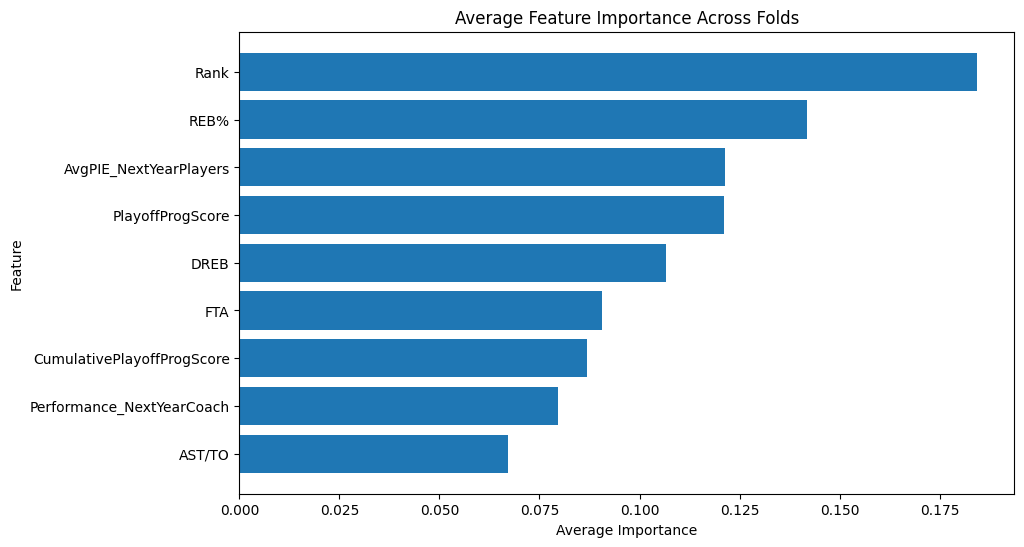

Mean Cross-Validation Accuracy: 0.8233333333333335
Mean Cross-Validation Precision: 0.7847041847041847
Mean Cross-Validation Recall: 0.9285714285714285
Mean Cross-Validation F1 Score: 0.8450971414206709
Mean Cross-Validation AUC Score: 0.8709183673469388
Mean Cross-Validation Specificity: 0.7160714285714286


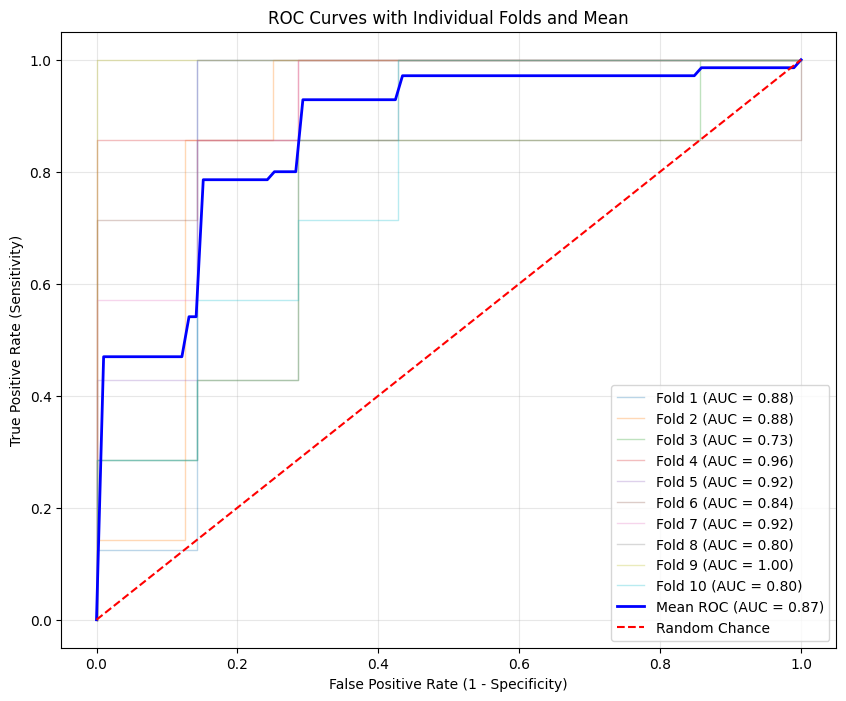

In [38]:
# ============================
# Final Evaluation
# ============================
cv_results = cross_validate(
    final_model, X, y, cv=skf, scoring=scoring, return_estimator=True, n_jobs=-1
)

feature_importances = []
for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

average_importances = np.mean(feature_importances, axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Importance': average_importances
}).sort_values(by='Average Importance', ascending=False)

# Display the feature importance table
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

# ROC Curve Visualization with Individual Folds
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()